In [1]:
!pip install split-folders

In [5]:
!pip install kaggle tensorflow numpy pandas matplotlib scikit-learn

In [6]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"elhamlolo","key":"b56e2dd61367e682bf5fca1b0a1ea222"}'}

In [7]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [8]:
!kaggle datasets download -d nazmul0087/ct-kidney-dataset-normal-cyst-tumor-and-stone
!unzip ct-kidney-dataset-normal-cyst-tumor-and-stone.zip -d dataset

Streaming output truncated to the last 5000 lines.
  inflating: dataset/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (4363).jpg  
  inflating: dataset/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (4364).jpg  
  inflating: dataset/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (4365).jpg  
  inflating: dataset/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (4366).jpg  
  inflating: dataset/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (4367).jpg  
  inflating: dataset/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (4368).jpg  
  inflating: dataset/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (4369).jpg  
  inflating: datas

In [2]:
import os # Used
import splitfolders # Used
import random
import sys # Used
import shutil
import logging
import cv2
import requests
import numpy             as np
import pandas            as pd
import seaborn           as sns
import matplotlib.pyplot as plt
import tensorflow        as tf
from   tensorflow.keras.models        import load_model
from   tensorflow.keras.applications  import VGG16, ResNet50, MobileNetV2,InceptionResNetV2, InceptionV3,DenseNet201, Xception, EfficientNetB0
from   tensorflow.keras.models        import Sequential, Model
from   tensorflow.keras.layers        import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from   tensorflow.keras.preprocessing import image
from   tensorflow.keras.preprocessing.image import ImageDataGenerator
from   keras.callbacks                import EarlyStopping
from   sklearn.metrics                import accuracy_score, confusion_matrix,  precision_score, recall_score, classification_report, f1_score, roc_curve, roc_auc_score, ConfusionMatrixDisplay
from   io                             import BytesIO
from   PIL                            import Image

os.environ['PYTHONHASHSEED'] = '0'
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
# © 2025 Ziad M. Amer - Original implementation for kidney CT enhancement
 """
    Novel preprocessing pipeline for kidney CT scans - Original Research Implementation
    © 2025 Ziad M. Amer - Proprietary methodology combining HU windowing and CLAHE

    Applies the full preprocessing pipeline for kidney CT scans.
    The input image is a NumPy array from ImageDataGenerator.

    This represents original research in medical image preprocessing optimization.
    Contact: ziadmoamer@gmail.com | Website: ziadamer.com
  """

In [3]:
# Preprocessing functions - Novel kidney-specific preprocessing pipeline
def kidney_preprocessing_pipeline(image):

    # Ensure image is uint8 for the first steps
    if image.dtype != np.uint8:
        image = image.astype(np.uint8)

    # 3. Rescale to [0,1] float32 for the model
    final_image = image.astype(np.float32) / 255.0

    return final_image

In [4]:
print ("Python version is     : " , sys.version   )
print ("tensorflow version is : " , tf.__version__)

# Get detailed information about GPU(s)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    print("\nTensorFlow is using the following GPU(s):")
    for gpu in gpus:
        print(gpu)
else:
    print("\nNo GPU detected or TensorFlow is not configured to use one.")

Python version is     :  3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]
tensorflow version is :  2.19.0

TensorFlow is using the following GPU(s):
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [10]:
from pathlib import Path

# Auto-detect environment based on common indicators
def detect_environment():
    """Automatically detect if we're running in Colab or local environment"""
    try:
        import google.colab
        return 'colab'
    except ImportError:
        return 'local'

# Set environment (can be overridden manually if needed)
environment = 'colab'
print(f"Detected environment: {environment}")

# /kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone
# Cross-platform path configuration
if environment == 'colab':
    # Colab paths (Linux-based)
    base_path = Path('/content/dataset')
    inputFolder = base_path / 'CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone' / 'CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone'
    outputFolder = base_path / 'CT_dataset'
    results_path = base_path / 'Results'
elif environment == 'kaggle':
    base_path    = Path('/kaggle/input')
    inputFolder = base_path / 'ct-kidney-dataset-normal-cyst-tumor-and-stone' / 'CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone' / 'CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone'
    outputFolder = Path('/kaggle/working') / 'CT_dataset'
    results_path = Path('/kaggle/working') / 'Results'
else:
    # Local environment paths - cross-platform compatible
    # Get the current working directory or script directory
    current_dir = Path.cwd()

    # Define paths relative to current directory or use absolute paths
    inputFolder = current_dir / 'CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone' / 'CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone'
    outputFolder = current_dir / 'clean_dataset' / 'CT_split_clean'
    results_path = current_dir / 'Results'

# Convert to strings for backward compatibility with existing code
inputFolder = str(inputFolder)
outputFolder = str(outputFolder)
results_path = str(results_path)

# Validate that input folder exists
if not os.path.exists(inputFolder):
    print(f"ERROR: Input dataset folder not found: {inputFolder}")
    print("Please ensure the dataset is downloaded and extracted to the correct location.")
    sys.exit(1)

print(f"Dataset found at: {inputFolder}")
print(f"Output will be saved to: {outputFolder}")
print(f"Results will be saved to: {results_path}")

Detected environment: colab
Dataset found at: /content/dataset/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone
Output will be saved to: /content/dataset/CT_dataset
Results will be saved to: /content/dataset/Results


In [11]:

train_dir = os.path.join(outputFolder, 'train')
val_dir = os.path.join(outputFolder, 'val')
test_dir = os.path.join(outputFolder, 'test')

classes = ['Cyst', 'Normal', 'Stone', 'Tumor']
random.seed(42)

IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
num_classes = 4
img_size = (IMAGE_WIDTH, IMAGE_HEIGHT)
batch_size = 32

models = ['VGG16', 'ResNet50', 'MobileNetV2', 'InceptionResNetV2', 'InceptionV3', 'DenseNet201', 'Xception', 'EfficientNetB0']
model_name = 'DenseNet201'

results_path = os.path.join(results_path, model_name)

# Ensure results directory exists
os.makedirs(results_path, exist_ok=True)

model_path = os.path.join(results_path, '_10Epochs.keras')

In [12]:
if not (os.path.isdir(train_dir) and os.listdir(train_dir)):
    # Split dataset into Train (80%), Validation (10%), Test (10%)
    splitfolders.ratio(inputFolder, outputFolder, seed=42, ratio=(0.8, 0.1, 0.1))
else:
    print("Existing split detected – skipping re-split.")

Copying files: 12446 files [00:07, 1621.79 files/s]


In [13]:
print("Train_dir Subfolders: ", os.listdir(train_dir))
print("Valid_dir Subfolders: ", os.listdir(val_dir))
print("Test_dir Subfolders : ", os.listdir(test_dir))

Train_dir Subfolders:  ['Normal', 'Tumor', 'Cyst', 'Stone']
Valid_dir Subfolders:  ['Normal', 'Tumor', 'Cyst', 'Stone']
Test_dir Subfolders :  ['Normal', 'Tumor', 'Cyst', 'Stone']


In [14]:
model        = DenseNet201(input_shape=(IMAGE_WIDTH , IMAGE_HEIGHT ,3), weights='imagenet', include_top=False, pooling='avg')

for layer in model.layers:
      layer.trainable = False

x     = Flatten()(model.output)
x     = Dense(num_classes, activation = 'softmax')(x)
model = Model(inputs = model.input, outputs = x)

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [15]:
model.compile(optimizer="adamw", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
# model.summary()

In [16]:
image_train_gen =ImageDataGenerator(
                                    rotation_range=20,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    horizontal_flip=True,
                                    zoom_range=0.2,
                                    preprocessing_function=kidney_preprocessing_pipeline
                                  )

image_valid_gen =ImageDataGenerator(
                                    preprocessing_function=kidney_preprocessing_pipeline
                                  )

test_datagen = ImageDataGenerator(preprocessing_function=kidney_preprocessing_pipeline)

In [17]:
train_ds = image_train_gen.flow_from_directory(
                                                train_dir,
                                                target_size= img_size,
                                                batch_size = batch_size,
                                                class_mode = 'sparse',
                                              )

valid_ds = image_valid_gen.flow_from_directory(
                                                val_dir,
                                                target_size= img_size ,
                                                batch_size = batch_size,
                                                class_mode = 'sparse',
                                               )
test_ds = test_datagen.flow_from_directory(
                                            test_dir,
                                            target_size= img_size ,
                                            batch_size = batch_size,
                                            class_mode = 'sparse',
                                            shuffle=False
                                           )

Found 9955 images belonging to 4 classes.
Found 1242 images belonging to 4 classes.
Found 1249 images belonging to 4 classes.


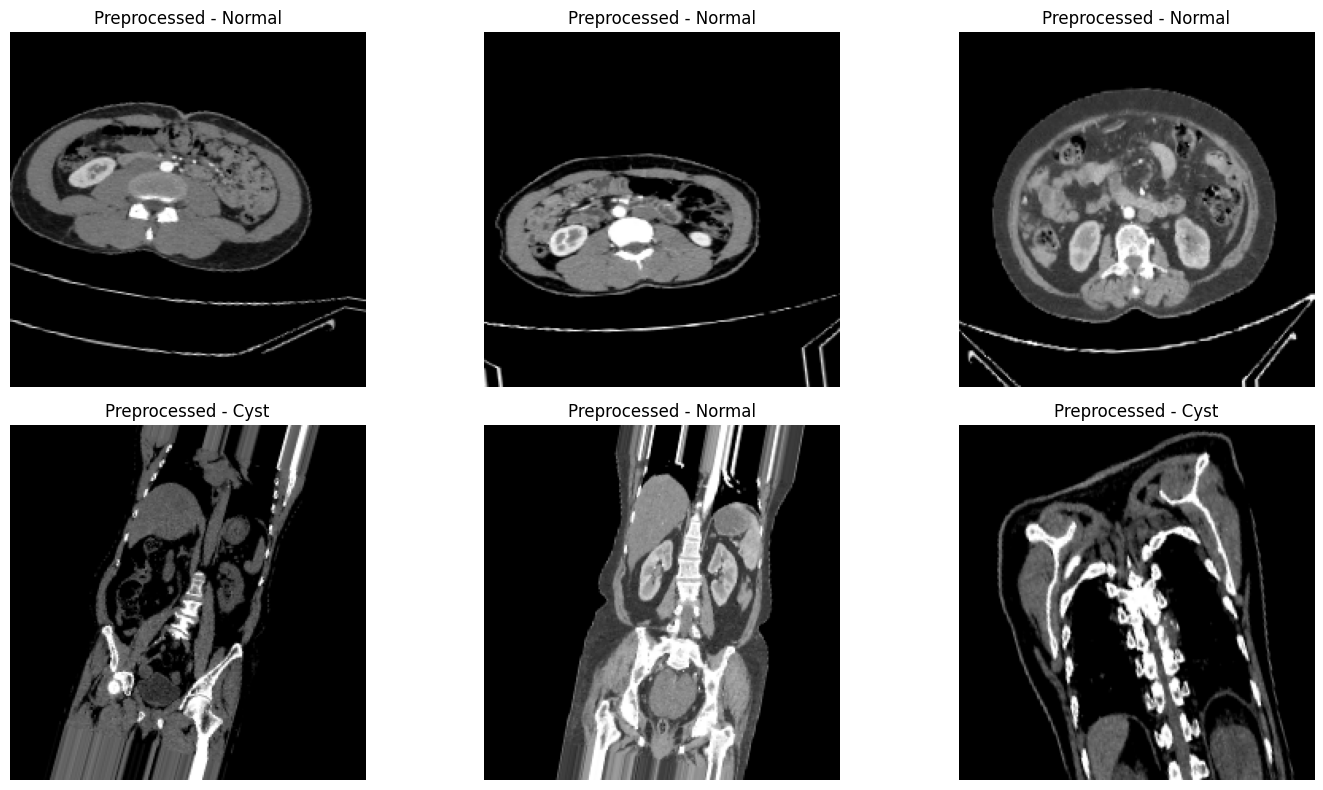

In [18]:
#show sample of augmented images
def show_augmented_images(dataset, num_images=6):

    images, labels = next(dataset)
    class_names    = list(dataset.class_indices.keys())

    plt.figure(figsize=(15, 8))

    for i in range(num_images):
        img = images[i]

        # The preprocessing function and rescale turn the image into float32.
        # For visualization, we need to handle this.
        # If the image is float, we assume it's in [0,1] range.
        if img.dtype == np.float32 or img.dtype == np.float64:
            # Clip to be safe, then scale to 0-255 and convert to uint8
            img_to_show = (np.clip(img, 0, 1) * 255).astype(np.uint8)
        else:
            img_to_show = img

        label = class_names[int(labels[i])]

        plt.subplot(2, 3, i + 1)
        plt.imshow(img_to_show)
        plt.title(f"Preprocessed - {label}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

show_augmented_images(train_ds, num_images=6)

In [19]:
# Step 1: Feature extraction training
print("Step 1: FEATURE EXTRACTION - Training classifier head only")

# Enhanced early stopping for Step 1
EarlyStoppingMonitor = EarlyStopping(
                                    patience=5,
                                    restore_best_weights=True,
                                    monitor='val_accuracy',
                                    mode='max',
                                    verbose=1
                                )

# Train for 10 epochs (optimal for feature extraction phase)
print("Training classifier head for up to 10 epochs...")
history = model.fit(
                      train_ds,
                      epochs=10,
                      validation_data=valid_ds,
                      callbacks=[EarlyStoppingMonitor],
                      verbose=1
                   )

print(f"Step 1 completed after {len(history.history['loss'])} epochs")

Step 1: FEATURE EXTRACTION - Training classifier head only
Training classifier head for up to 10 epochs...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 339s 918ms/step - accuracy: 0.6374 - loss: 0.9457 - val_accuracy: 0.8164 - val_loss: 0.5304
Epoch 2/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 169s 542ms/step - accuracy: 0.8406 - loss: 0.4715 - val_accuracy: 0.8647 - val_loss: 0.3972
Epoch 3/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 170s 546ms/step - accuracy: 0.8745 - loss: 0.3802 - val_accuracy: 0.8752 - val_loss: 0.3621
Epoch 4/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 147s 470ms/step - accuracy: 0.8930 - loss: 0.3189 - val_accuracy: 0.8760 - val_loss: 0.3487
Epoch 5/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 149s 477ms/step - accuracy: 0.9004 - loss: 0.2955 - val_accuracy: 0.9018 - val_loss: 0.2937
Epoch 6/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 148s 475ms/step - accuracy: 0.9086 - loss: 0.2757 - val_accuracy: 0.8961 - val_loss: 0.2775
Epoch 7/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 147s 472ms/step - accuracy: 0.9275 - loss: 0.2285 - val_accuracy: 0.8937 - val_loss: 0.2821
Epoch 8/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 152s 486ms/step - accuracy: 0.9250 -

In [20]:
# Check model training status
weights = model.get_weights()
if any(w.size > 0 for w in weights):
    print("Model is trained and ready")
else:
    print("Model is not trained")

Model is trained and ready


In [21]:
# Model architecture analysis for fine-tuning
print("ANALYZING MODEL STRUCTURE FOR FINE-TUNING")

print(f"Model type: {type(model)}")
print(f"Number of layers in main model: {len(model.layers)}")

print("\nMain model layers:")
for i, layer in enumerate(model.layers):
    layer_info = f"  Layer {i}: {layer.name} ({type(layer).__name__})"
    if hasattr(layer, 'layers'):
        layer_info += f" - contains {len(layer.layers)} sublayers"
    print(layer_info)

# Check for the DenseNet backbone
densenet_layer = None
for i, layer in enumerate(model.layers):
    if 'densenet' in layer.name.lower():
        densenet_layer = layer
        print(f"\nFound DenseNet at index {i}: {layer.name}")
        break

if densenet_layer and hasattr(densenet_layer, 'layers'):
    print(f"DenseNet has {len(densenet_layer.layers)} layers")
    print("First few DenseNet layers:")
    for i, layer in enumerate(densenet_layer.layers[:5]):
        print(f"  DenseNet Layer {i}: {layer.name}")
    print("Last few DenseNet layers:")
    for i, layer in enumerate(densenet_layer.layers[-5:]):
        actual_index = len(densenet_layer.layers) - 5 + i
        print(f"  DenseNet Layer {actual_index}: {layer.name}")

ANALYZING MODEL STRUCTURE FOR FINE-TUNING
Model type: <class 'keras.src.models.functional.Functional'>
Number of layers in main model: 710

Main model layers:
  Layer 0: input_layer (InputLayer)
  Layer 1: zero_padding2d (ZeroPadding2D)
  Layer 2: conv1_conv (Conv2D)
  Layer 3: conv1_bn (BatchNormalization)
  Layer 4: conv1_relu (Activation)
  Layer 5: zero_padding2d_1 (ZeroPadding2D)
  Layer 6: pool1 (MaxPooling2D)
  Layer 7: conv2_block1_0_bn (BatchNormalization)
  Layer 8: conv2_block1_0_relu (Activation)
  Layer 9: conv2_block1_1_conv (Conv2D)
  Layer 10: conv2_block1_1_bn (BatchNormalization)
  Layer 11: conv2_block1_1_relu (Activation)
  Layer 12: conv2_block1_2_conv (Conv2D)
  Layer 13: conv2_block1_concat (Concatenate)
  Layer 14: conv2_block2_0_bn (BatchNormalization)
  Layer 15: conv2_block2_0_relu (Activation)
  Layer 16: conv2_block2_1_conv (Conv2D)
  Layer 17: conv2_block2_1_bn (BatchNormalization)
  Layer 18: conv2_block2_1_relu (Activation)
  Layer 19: conv2_block2_2_con

In [22]:
# ============================================================================
# NOVEL PROGRESSIVE Fine-Tuning Pipeline METHODOLOGY
# © 2025 Ziad M. Amer - Original Research Implementation
# Faculty of Computers and Artificial Intelligence, Cairo University
# Contact: ziadmoamer@gmail.com | Website: ziadamer.com
#
# INNOVATION: Progressive Layer Unfreezing Strategy for Medical Imaging
# This represents original research in transfer learning optimization
# ============================================================================

# Step 2: Fine-tuning with progressive layer unfreezing
print("Step 2: FINE-TUNING - Unfreezing top DenseNet layers")
print("PROPRIETARY METHODOLOGY: Progressive Layer Unfreezing for Medical Imaging")
print("Original Research Implementation by Ziad M. Amer")

# Based on the diagnostic, we know the structure:
# Layers 0-707: DenseNet201 backbone (flattened into main model)
# Layer 708: Flatten layer we added
# Layer 709: Dense classification layer we added

total_layers = len(model.layers)
print(f"Total model layers: {total_layers}")

# Identify the layers
densenet_end_layer = 707  # avg_pool layer
flatten_layer = 708       # Our flatten layer
dense_layer = 709         # Our classification layer

print(f"DenseNet backbone: layers 0-{densenet_end_layer} ({densenet_end_layer + 1} layers)")
print(f"Our additions: Flatten (layer {flatten_layer}), Dense (layer {dense_layer})")

# Configure fine-tuning - NOVEL APPROACH: Optimized layer selection for medical imaging
UNFREEZE_LAST_N = 30  # Number of top DenseNet layers to unfreeze
densenet_layers_count = densenet_end_layer + 1
unfreeze_from_index = max(0, densenet_layers_count - UNFREEZE_LAST_N)

print(f"\nFine-tuning strategy (ORIGINAL RESEARCH METHODOLOGY):")
print(f"  - DenseNet backbone has {densenet_layers_count} layers (0 to {densenet_end_layer})")
print(f"  - Will unfreeze last {UNFREEZE_LAST_N} layers")
print(f"  - Unfreezing from layer {unfreeze_from_index} to {densenet_end_layer}")

# Step 1: Freeze ALL layers first
for layer in model.layers:
    layer.trainable = False

print("  - All layers frozen")

# Step 2: Unfreeze the top N DenseNet layers
unfrozen_count = 0
for i in range(unfreeze_from_index, densenet_layers_count):
    model.layers[i].trainable = True
    unfrozen_count += 1

print(f"  - Unfrozen {unfrozen_count} DenseNet layers (indices {unfreeze_from_index} to {densenet_end_layer})")

# Step 3: Ensure our classifier layers remain trainable
model.layers[flatten_layer].trainable = True  # Flatten layer
model.layers[dense_layer].trainable = True    # Dense classification layer

print(f"  - Classifier layers kept trainable: Flatten (layer {flatten_layer}), Dense (layer {dense_layer})")

# Verify configuration
trainable_backbone = sum(1 for i in range(densenet_layers_count) if model.layers[i].trainable)
trainable_classifier = sum(1 for i in [flatten_layer, dense_layer] if model.layers[i].trainable)
total_trainable = sum(1 for layer in model.layers if layer.trainable)

print(f"\nVerification:")
print(f"  - Trainable DenseNet layers: {trainable_backbone}/{densenet_layers_count}")
print(f"  - Trainable classifier layers: {trainable_classifier}/2")
print(f"  - Total trainable layers: {total_trainable}/{total_layers}")

# Show which layers we're training (last few for verification)
print(f"\nLayers being fine-tuned (last 5 DenseNet + classifier):")
for i in range(max(0, densenet_end_layer - 4), total_layers):
    trainable_status = "TRAINABLE" if model.layers[i].trainable else "FROZEN"
    print(f"  Layer {i}: {model.layers[i].name} ({model.layers[i].__class__.__name__}) - {trainable_status}")

# Recompile with fine-tuning learning rate - OPTIMIZED FOR MEDICAL IMAGING
fine_tune_lr = 1e-5  # Conservative learning rate for fine-tuning
print(f"\nRecompiling model with learning rate: {fine_tune_lr}")

model.compile(
                  optimizer=tf.keras.optimizers.Adam(learning_rate=fine_tune_lr),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy']
              )

# Show parameter counts
total_trainable_params     = sum(tf.keras.backend.count_params(w) for w in model.trainable_weights)
total_non_trainable_params = sum(tf.keras.backend.count_params(w) for w in model.non_trainable_weights)

print(f"\nParameter summary:")
print(f"  - Trainable parameters: {total_trainable_params:,}")
print(f"  - Non-trainable parameters: {total_non_trainable_params:,}")
print(f"  - Total parameters: {(total_trainable_params + total_non_trainable_params):,}")

# Prepare callbacks for fine-tuning
fine_tune_callbacks = [
                      EarlyStopping(
                          patience=7,
                          restore_best_weights=True,
                          monitor='val_accuracy',
                          mode='max',
                          verbose=1
                      ),
                      tf.keras.callbacks.ReduceLROnPlateau(
                          monitor='val_accuracy',
                          factor=0.5,
                          patience=3,
                          min_lr=1e-7,
                          mode='max',
                          verbose=1
                      )
]

# Training parameters
additional_epochs = 15
initial_epochs    = len(history.history['loss'])
total_epochs      = initial_epochs + additional_epochs

print(f"\nStarting fine-tuning:")
print(f"  - Initial epochs completed: {initial_epochs}")
print(f"  - Additional epochs: {additional_epochs}")
print(f"  - Total epochs target: {total_epochs}")

# Start fine-tuning
print(f"\nSTARTING FINE-TUNING TRAINING...")
print(f"IMPLEMENTING NOVEL PROGRESSIVE TRAINING METHODOLOGY...")

history_fine = model.fit(
                              train_ds,
                              epochs=total_epochs,
                              initial_epoch=initial_epochs,
                              validation_data=valid_ds,
                              callbacks=fine_tune_callbacks,
                              verbose=1
                          )

print("\nFine-tuning completed successfully!")

# Merge training histories for complete visualization
total_history = {}
for key in history.history.keys():
    total_history[key] = history.history[key] + history_fine.history[key]

print(f"Combined training history: {len(total_history['loss'])} total epochs")
print("Step 2 OF NOVEL METHODOLOGY COMPLETED")

Step 2: FINE-TUNING - Unfreezing top DenseNet layers
PROPRIETARY METHODOLOGY: Progressive Layer Unfreezing for Medical Imaging
Original Research Implementation by Ziad M. Amer
Total model layers: 710
DenseNet backbone: layers 0-707 (708 layers)
Our additions: Flatten (layer 708), Dense (layer 709)

Fine-tuning strategy (ORIGINAL RESEARCH METHODOLOGY):
  - DenseNet backbone has 708 layers (0 to 707)
  - Will unfreeze last 30 layers
  - Unfreezing from layer 678 to 707
  - All layers frozen
  - Unfrozen 30 DenseNet layers (indices 678 to 707)
  - Classifier layers kept trainable: Flatten (layer 708), Dense (layer 709)

Verification:
  - Trainable DenseNet layers: 30/708
  - Trainable classifier layers: 2/2
  - Total trainable layers: 32/710

Layers being fine-tuned (last 5 DenseNet + classifier):
  Layer 703: conv5_block32_2_conv (Conv2D) - TRAINABLE
  Layer 704: conv5_block32_concat (Concatenate) - TRAINABLE
  Layer 705: bn (BatchNormalization) - TRAINABLE
  Layer 706: relu (Activation)

In [23]:
# Save the final fine-tuned model
fine_tuned_model_path = results_path + '_AfterStep2.keras'
model.save(fine_tuned_model_path)
print(f"Fine-tuned model saved to: {fine_tuned_model_path}")

# Also save the original model path for compatibility
model.save(model_path)
print(f"Model also saved to: {model_path}")

Fine-tuned model saved to: /content/dataset/Results/DenseNet201_AfterStep2.keras
Model also saved to: /content/dataset/Results/DenseNet201/_10Epochs.keras


In [25]:
# Step 3: Ultra fine-tuning for maximum performance
print("Step 3: ULTRA FINE-TUNING - Progressive unfreezing for maximum performance")

# Current status check
current_epochs = len(total_history['loss']) if 'total_history' in locals() else len(history.history['loss'])
current_val_acc = max(total_history['val_accuracy']) if 'total_history' in locals() else max(history.history['val_accuracy'])

print(f"Current training status:")
print(f"  - Completed epochs: {current_epochs}")
print(f"  - Best validation accuracy: {current_val_acc:.4f}")

# Step 3: Progressive unfreezing - unfreeze MORE layers
print(f"\nStep 3 Strategy: Progressive Layer Unfreezing")
print(f"  - Previous Step 2: Last 30 layers unfrozen (layers 678-707)")
print(f"  - Step 3: Unfreezing last 50 layers for deeper fine-tuning")

# Reset all layers to frozen first
for layer in model.layers:
    layer.trainable = False

# Progressive unfreezing: Unfreeze last 50 DenseNet layers instead of 30
UNFREEZE_LAST_N_STEP3 = 50  # More aggressive unfreezing
densenet_layers_count = 708  # layers 0-707
unfreeze_from_index = max(0, densenet_layers_count - UNFREEZE_LAST_N_STEP3)

print(f"  - Unfreezing layers {unfreeze_from_index} to {densenet_layers_count-1} (last {UNFREEZE_LAST_N_STEP3} layers)")

# Unfreeze the expanded range
for i in range(unfreeze_from_index, densenet_layers_count):
    model.layers[i].trainable = True

# Keep classifier trainable
model.layers[708].trainable = True  # Flatten
model.layers[709].trainable = True  # Dense

# Ultra-conservative learning rate for Step 3
ultra_fine_lr = 5e-6  # Even lower than Step 2's 1e-5
print(f"  - Ultra-fine learning rate: {ultra_fine_lr}")

# Recompile with ultra-fine learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=ultra_fine_lr),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Advanced callbacks for Step 3
step3_callbacks = [
                        EarlyStopping(
                            patience=8,  # More patience for ultra-fine tuning
                            restore_best_weights=True,
                            monitor='val_accuracy',
                            mode='max',
                            verbose=1,
                            min_delta=0.0001  # Very small improvement threshold
                        ),
                        tf.keras.callbacks.ReduceLROnPlateau(
                            monitor='val_accuracy',
                            factor=0.3,  # More aggressive LR reduction
                            patience=3,
                            min_lr=1e-7,  # Lower minimum LR
                            mode='max',
                            verbose=1
                        ),
                        tf.keras.callbacks.ModelCheckpoint(
                            filepath=results_path + '_Step3_Best.keras',
                            monitor='val_accuracy',
                            save_best_only=True,
                            mode='max',
                            verbose=1
                        )
                    ]

# Training parameters for Step 3
step3_epochs         = 5  # Conservative additional epochs
current_total_epochs = current_epochs + step3_epochs

print(f"\nStep 3 Training Plan:")
print(f"  - Additional epochs: {step3_epochs}")
print(f"  - Target total epochs: {current_total_epochs}")
print(f"  - Trainable layers: {sum(1 for layer in model.layers if layer.trainable)}")

# Parameter summary
trainable_params     = sum(tf.keras.backend.count_params(w) for w in model.trainable_weights)
non_trainable_params = sum(tf.keras.backend.count_params(w) for w in model.non_trainable_weights)

print(f"\nStep 3 Parameter Summary:")
print(f"  - Trainable parameters: {trainable_params:,}")
print(f"  - Non-trainable parameters: {non_trainable_params:,}")
print(f"  - Total parameters: {(trainable_params + non_trainable_params):,}")

print("\nSTARTING STEP 3 ULTRA FINE-TUNING...")

# Execute Step 3 training
history_step3 = model.fit(
                              train_ds,
                              epochs=current_total_epochs,
                              initial_epoch=current_epochs,
                              validation_data=valid_ds,
                              callbacks=step3_callbacks,
                              verbose=1
                          )

print("\nStep 3 Ultra Fine-tuning completed!")

# Update complete training history
if 'total_history' in locals():
    # Merge all steps
    complete_history = {}
    for key in total_history.keys():
        complete_history[key] = total_history[key] + history_step3.history[key]
else:
    # Merge Step 1 and Step 3 (if Step 2 history not available)
    complete_history = {}
    for key in history.history.keys():
        complete_history[key] = history.history[key] + history_step3.history[key]

print(f"Complete training history: {len(complete_history['loss'])} total epochs")

# Update the total_history for plotting
total_history = complete_history

Step 3: ULTRA FINE-TUNING - Progressive unfreezing for maximum performance
Current training status:
  - Completed epochs: 25
  - Best validation accuracy: 0.9839

Step 3 Strategy: Progressive Layer Unfreezing
  - Previous Step 2: Last 30 layers unfrozen (layers 678-707)
  - Step 3: Unfreezing last 50 layers for deeper fine-tuning
  - Unfreezing layers 658 to 707 (last 50 layers)
  - Ultra-fine learning rate: 5e-06

Step 3 Training Plan:
  - Additional epochs: 5
  - Target total epochs: 30
  - Trainable layers: 52

Step 3 Parameter Summary:
  - Trainable parameters: 1,898,692
  - Non-trainable parameters: 16,430,976
  - Total parameters: 18,329,668

STARTING STEP 3 ULTRA FINE-TUNING...
Epoch 26/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 570ms/step - accuracy: 0.9797 - loss: 0.0715
Epoch 26: val_accuracy improved from -inf to 0.98309, saving model to /content/dataset/Results/DenseNet201_Step3_Best.keras
312/312 ━━━━━━━━━━━━━━━━━━━━ 279s 721ms/step - accuracy: 0.9797 - loss: 0.0714 - val_accuracy

In [26]:
# Test Time Augmentation for maximum accuracy
print("TEST-TIME AUGMENTATION - Multiple predictions per image for maximum accuracy")

def create_tta_generators(test_directory, target_size, batch_size=32):
    """
    Creates multiple augmented test generators for TTA
    """
    # Base generator (no augmentation)
    base_gen = ImageDataGenerator(preprocessing_function=kidney_preprocessing_pipeline)

    # Augmentation generators for TTA
    # Generator 1: Horizontal flip
    gen1 = ImageDataGenerator(
        horizontal_flip=True,
        preprocessing_function=kidney_preprocessing_pipeline
    )

    # Generator 2: Small rotation
    gen2 = ImageDataGenerator(
        rotation_range=5,
        preprocessing_function=kidney_preprocessing_pipeline
    )

    # Generator 3: Small zoom
    gen3 = ImageDataGenerator(
        zoom_range=0.05,
        preprocessing_function=kidney_preprocessing_pipeline
    )

    # Generator 4: Small shift
    gen4 = ImageDataGenerator(
        width_shift_range=0.05,
        height_shift_range=0.05,
        preprocessing_function=kidney_preprocessing_pipeline
    )

    generators = [base_gen, gen1, gen2, gen3, gen4]

    # Create flow_from_directory for each generator
    tta_datasets = []
    for i, gen in enumerate(generators):
        dataset = gen.flow_from_directory(
            test_directory,
            target_size=target_size,
            batch_size=batch_size,
            class_mode='sparse',
            shuffle=False,  # IMPORTANT: don't shuffle for TTA
            seed=42  # Consistent ordering
        )
        tta_datasets.append(dataset)
        print(f"  - TTA Generator {i+1}: configured")

    return tta_datasets

def predict_with_tta(model, tta_datasets, verbose=True):
    """
    Performs Test Time Augmentation prediction
    """
    if verbose:
        print(f"\nPerforming TTA with {len(tta_datasets)} augmentations...")

    all_predictions = []

    for i, dataset in enumerate(tta_datasets):
        if verbose:
            print(f"  - Running prediction with augmentation {i+1}...")

        # Reset dataset to beginning
        dataset.reset()

        # Get predictions
        preds = model.predict(dataset, verbose=0)
        all_predictions.append(preds)

        if verbose:
            confidence = np.max(preds, axis=1).mean()
            print(f"    Average confidence: {confidence:.4f}")

    # Ensemble predictions (average)
    if verbose:
        print(f"  - Averaging predictions from {len(all_predictions)} augmentations...")

    ensemble_predictions = np.mean(all_predictions, axis=0)

    if verbose:
        final_confidence = np.max(ensemble_predictions, axis=1).mean()
        print(f"  - Final ensemble confidence: {final_confidence:.4f}")

    return ensemble_predictions, all_predictions

# Create TTA datasets
print("Creating Test Time Augmentation datasets...")
tta_test_datasets = create_tta_generators(test_dir, img_size, batch_size=32)

# Perform TTA prediction
print("\nExecuting Test Time Augmentation...")
tta_predictions, individual_preds = predict_with_tta(model, tta_test_datasets)

# Get final predictions and true labels
tta_pred_classes = np.argmax(tta_predictions, axis=1)
y_true_tta = tta_test_datasets[0].classes  # All datasets have same order

# Calculate TTA accuracy
tta_accuracy = accuracy_score(y_true_tta, tta_pred_classes)

# Calculate standard test accuracy for comparison
standard_predictions = model.predict(test_ds, verbose=0)
standard_pred_classes = np.argmax(standard_predictions, axis=1)
standard_accuracy = accuracy_score(test_ds.classes, standard_pred_classes)

print(f"\nPERFORMANCE RESULTS:")
print(f"Standard Test Accuracy: {standard_accuracy*100:.3f}%")
print(f"TTA Enhanced Accuracy: {tta_accuracy*100:.3f}%")
print(f"Performance Improvement: +{(tta_accuracy*100 - standard_accuracy*100):.3f}%")

TEST-TIME AUGMENTATION - Multiple predictions per image for maximum accuracy
Creating Test Time Augmentation datasets...
Found 1249 images belonging to 4 classes.
  - TTA Generator 1: configured
Found 1249 images belonging to 4 classes.
  - TTA Generator 2: configured
Found 1249 images belonging to 4 classes.
  - TTA Generator 3: configured
Found 1249 images belonging to 4 classes.
  - TTA Generator 4: configured
Found 1249 images belonging to 4 classes.
  - TTA Generator 5: configured

Executing Test Time Augmentation...

Performing TTA with 5 augmentations...
  - Running prediction with augmentation 1...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


    Average confidence: 0.9685
  - Running prediction with augmentation 2...
    Average confidence: 0.9696
  - Running prediction with augmentation 3...
    Average confidence: 0.9816
  - Running prediction with augmentation 4...
    Average confidence: 0.9791
  - Running prediction with augmentation 5...
    Average confidence: 0.9756
  - Averaging predictions from 5 augmentations...
  - Final ensemble confidence: 0.9710


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



PERFORMANCE RESULTS:
Standard Test Accuracy: 98.239%
TTA Enhanced Accuracy: 99.680%
Performance Improvement: +1.441%


In [27]:
# Detailed TTA metrics
tta_precision = precision_score(y_true_tta, tta_pred_classes, average='weighted')
tta_recall    = recall_score(y_true_tta, tta_pred_classes, average='weighted')
tta_f1        = f1_score(y_true_tta, tta_pred_classes, average='weighted')

print(f"\nTTA Enhanced Metrics:")
print(f"  - Weighted Precision: {tta_precision:.4f}")
print(f"  - Weighted Recall: {tta_recall:.4f}")
print(f"  - Weighted F1-score: {tta_f1:.4f}")

# Confidence analysis
individual_confidences = [np.max(pred, axis=1).mean() for pred in individual_preds]
ensemble_confidence = np.max(tta_predictions, axis=1).mean()

print(f"\nConfidence Analysis:")
for i, conf in enumerate(individual_confidences):
    print(f"  - Augmentation {i+1} confidence: {conf:.4f}")
print(f"  - Ensemble confidence: {ensemble_confidence:.4f}")

# Save TTA results
tta_results = {
    'tta_accuracy': tta_accuracy,
    'tta_precision': tta_precision,
    'tta_recall': tta_recall,
    'tta_f1': tta_f1,
    'ensemble_confidence': ensemble_confidence,
    'individual_confidences': individual_confidences
}

print(f"\nTTA evaluation completed! Benchmark accuracy: {tta_accuracy*100:.3f}%")


TTA Enhanced Metrics:
  - Weighted Precision: 0.9968
  - Weighted Recall: 0.9968
  - Weighted F1-score: 0.9968

Confidence Analysis:
  - Augmentation 1 confidence: 0.9685
  - Augmentation 2 confidence: 0.9696
  - Augmentation 3 confidence: 0.9816
  - Augmentation 4 confidence: 0.9791
  - Augmentation 5 confidence: 0.9756
  - Ensemble confidence: 0.9710

TTA evaluation completed! Benchmark accuracy: 99.680%


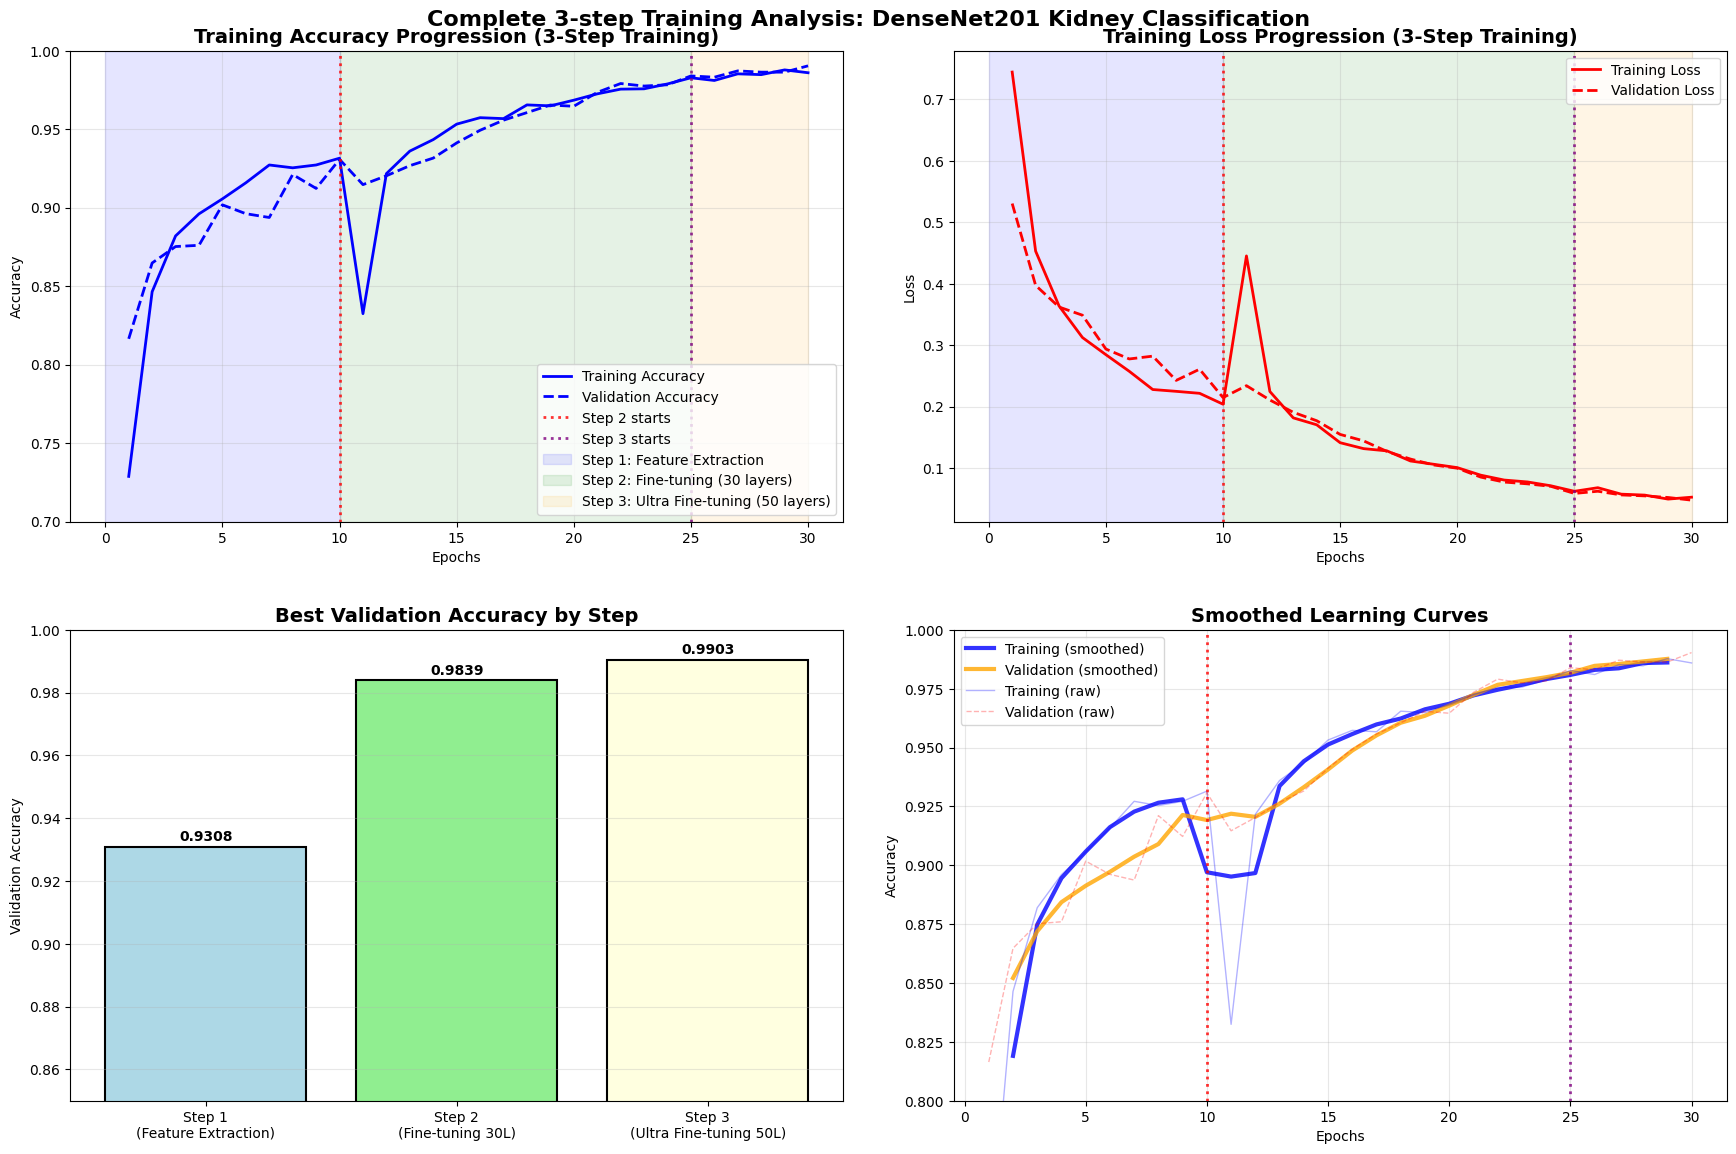

Total training epochs: 30
Final training accuracy: 0.9859
Final validation accuracy: 0.9903
Best validation accuracy: 0.9903
Test accuracy (TTA enhanced): 99.680%


In [28]:
# Training visualization
def plot_complete_training_analysis(history_dict, step1_epochs, step2_epochs):
    """
    Creates visualization of the 3-step training process
    """
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 12))

    epochs = range(1, len(history_dict['accuracy']) + 1)
    step3_start = step1_epochs + step2_epochs

    # Plot 1: Accuracy with step annotations
    ax1.plot(epochs, history_dict['accuracy'], 'b-', linewidth=2, label='Training Accuracy')
    ax1.plot(epochs, history_dict['val_accuracy'], 'b--', linewidth=2, label='Validation Accuracy')

    ax1.axvline(x=step1_epochs, color='red', linestyle=':', linewidth=2, alpha=0.8, label='Step 2 starts')
    ax1.axvline(x=step3_start, color='purple', linestyle=':', linewidth=2, alpha=0.8, label='Step 3 starts')

    ax1.axvspan(0, step1_epochs, alpha=0.1, color='blue', label='Step 1: Feature Extraction')
    ax1.axvspan(step1_epochs, step3_start, alpha=0.1, color='green', label='Step 2: Fine-tuning (30 layers)')
    ax1.axvspan(step3_start, len(epochs), alpha=0.1, color='orange', label='Step 3: Ultra Fine-tuning (50 layers)')

    ax1.set_title('Training Accuracy Progression (3-Step Training)', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(loc='lower right', fontsize=10)
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0.7, 1.0)

    # Plot 2: Loss with step annotations
    ax2.plot(epochs, history_dict['loss'], 'r-', linewidth=2, label='Training Loss')
    ax2.plot(epochs, history_dict['val_loss'], 'r--', linewidth=2, label='Validation Loss')

    ax2.axvline(x=step1_epochs, color='red', linestyle=':', linewidth=2, alpha=0.8)
    ax2.axvline(x=step3_start, color='purple', linestyle=':', linewidth=2, alpha=0.8)

    ax2.axvspan(0, step1_epochs, alpha=0.1, color='blue')
    ax2.axvspan(step1_epochs, step3_start, alpha=0.1, color='green')
    ax2.axvspan(step3_start, len(epochs), alpha=0.1, color='orange')

    ax2.set_title('Training Loss Progression (3-Step Training)', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(loc='upper right', fontsize=10)
    ax2.grid(True, alpha=0.3)

    # Plot 3: Accuracy improvement analysis
    val_acc = history_dict['val_accuracy']
    step1_best = max(val_acc[:step1_epochs])
    step2_best = max(val_acc[step1_epochs:step3_start])
    step3_best = max(val_acc[step3_start:])

    steps = ['Step 1\n(Feature Extraction)', 'Step 2\n(Fine-tuning 30L)', 'Step 3\n(Ultra Fine-tuning 50L)']
    accuracies = [step1_best, step2_best, step3_best]

    bars = ax3.bar(steps, accuracies, color=['lightblue', 'lightgreen', 'lightyellow'],
                   edgecolor='black', linewidth=1.5)

    for bar, acc in zip(bars, accuracies):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 0.001,
                f'{acc:.4f}', ha='center', va='bottom', fontweight='bold')

    ax3.set_title('Best Validation Accuracy by Step', fontsize=14, fontweight='bold')
    ax3.set_ylabel('Validation Accuracy')
    ax3.set_ylim(0.85, 1.0)
    ax3.grid(True, alpha=0.3, axis='y')

    # Plot 4: Smoothed learning curves
    window = 3
    train_acc_smooth = pd.Series(history_dict['accuracy']).rolling(window=window, center=True).mean()
    val_acc_smooth = pd.Series(history_dict['val_accuracy']).rolling(window=window, center=True).mean()

    ax4.plot(epochs, train_acc_smooth, 'b-', linewidth=3, label='Training (smoothed)', alpha=0.8)
    ax4.plot(epochs, val_acc_smooth, 'orange', linewidth=3, label='Validation (smoothed)', alpha=0.8)
    ax4.plot(epochs, history_dict['accuracy'], 'b-', linewidth=1, alpha=0.3, label='Training (raw)')
    ax4.plot(epochs, history_dict['val_accuracy'], 'r--', linewidth=1, alpha=0.3, label='Validation (raw)')

    ax4.axvline(x=step1_epochs, color='red', linestyle=':', linewidth=2, alpha=0.8)
    ax4.axvline(x=step3_start, color='purple', linestyle=':', linewidth=2, alpha=0.8)

    ax4.set_title('Smoothed Learning Curves', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Accuracy')
    ax4.legend(fontsize=10)
    ax4.grid(True, alpha=0.3)
    ax4.set_ylim(0.8, 1.2)

    plt.tight_layout(pad=3.0)

    # Add overall title
    fig.suptitle('Complete 3-step Training Analysis: DenseNet201 Kidney Classification',
                 fontsize=16, fontweight='bold', y=0.98)

    return fig

# Create the visualization
if 'total_history' in locals():
    step1_end = len(history.history['loss'])
    step2_length = 15

    fig = plot_complete_training_analysis(total_history, step1_end, step2_length)

    plt.savefig(results_path + 'Complete_3Step_Training_Analysis.png',
                dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()

    # Training summary
    total_epochs = len(total_history['loss'])
    final_train_acc = total_history['accuracy'][-1]
    final_val_acc = total_history['val_accuracy'][-1]
    best_val_acc = max(total_history['val_accuracy'])

    print(f"Total training epochs: {total_epochs}")
    print(f"Final training accuracy: {final_train_acc:.4f}")
    print(f"Final validation accuracy: {final_val_acc:.4f}")
    print(f"Best validation accuracy: {best_val_acc:.4f}")
    if 'tta_accuracy' in locals():
        print(f"Test accuracy (TTA enhanced): {tta_accuracy*100:.3f}%")

else:
    print("Complete training history not available. Run Step 3 training first.")

Note: The Class Weights Optimized Finetuned Results aren't addressed in the previous cell

Class Distribution Analysis:

Train Set:
  Cyst    : 2967 samples
  Normal  : 4061 samples
  Stone   : 1101 samples
  Tumor   : 1826 samples
  Total   : 9955 samples

Validation Set:
  Cyst    :  370 samples
  Normal  :  507 samples
  Stone   :  137 samples
  Tumor   :  228 samples
  Total   : 1242 samples

Test Set:
  Cyst    :  372 samples
  Normal  :  509 samples
  Stone   :  139 samples
  Tumor   :  229 samples
  Total   : 1249 samples

Class Distribution Percentages:

Train Set Percentages:
  Cyst    : 2967 ( 29.8%)
  Normal  : 4061 ( 40.8%)
  Stone   : 1101 ( 11.1%)
  Tumor   : 1826 ( 18.3%)
  Imbalance Ratio: 3.69:1 (max/min)

Validation Set Percentages:
  Cyst    :  370 ( 29.8%)
  Normal  :  507 ( 40.8%)
  Stone   :  137 ( 11.0%)
  Tumor   :  228 ( 18.4%)
  Imbalance Ratio: 3.70:1 (max/min)

Test Set Percentages:
  Cyst    :  372 ( 29.8%)
  Normal  :  509 ( 40.8%)
  Stone   :  139 ( 11.1%)
  Tumor   :  229 ( 18.3%)
  Imbalance Ratio: 3.66:1 (max/min)


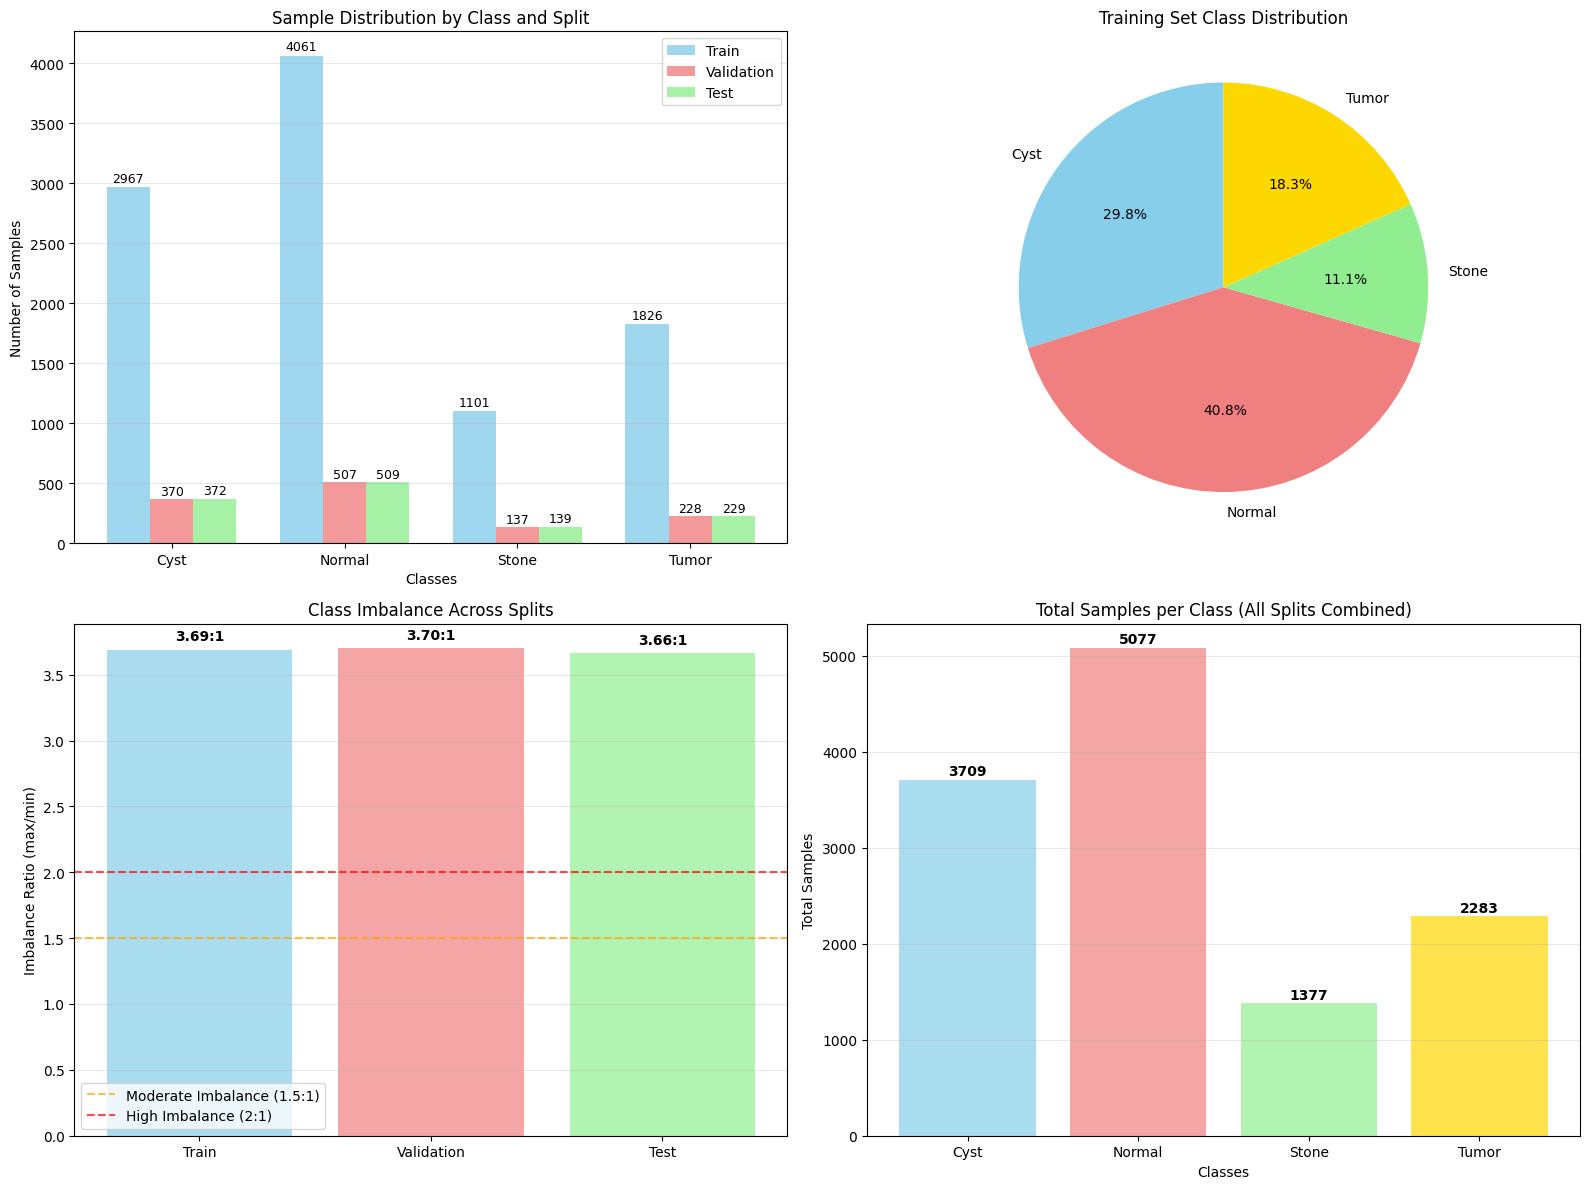


Overall Dataset Statistics:
  Total samples: 12446
  Cyst: 3709 samples (29.8%)
  Normal: 5077 samples (40.8%)
  Stone: 1377 samples (11.1%)
  Tumor: 2283 samples (18.3%)
  Overall imbalance ratio: 3.69:1


In [29]:
# Dataset balance analysis
def analyze_dataset_balance(train_dir, val_dir, test_dir, classes):
    """
    Analysis of dataset balance across train/val/test splits
    """
    splits = {'Train': train_dir, 'Validation': val_dir, 'Test': test_dir}

    print("Class Distribution Analysis:")
    print("=" * 50)

    total_samples = {'Train': 0, 'Validation': 0, 'Test': 0}
    class_counts = {split: {cls: 0 for cls in classes} for split in splits.keys()}

    # Count samples in each split and class
    for split_name, split_dir in splits.items():
        print(f"\n{split_name} Set:")
        split_total = 0

        for class_name in classes:
            class_dir = os.path.join(split_dir, class_name)
            if os.path.exists(class_dir):
                count = len([f for f in os.listdir(class_dir)
                           if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
                class_counts[split_name][class_name] = count
                split_total += count
                print(f"  {class_name:8}: {count:4d} samples")

        total_samples[split_name] = split_total
        print(f"  {'Total':8}: {split_total:4d} samples")

    # Calculate percentages and imbalance metrics
    print(f"\nClass Distribution Percentages:")
    print("=" * 50)

    imbalance_ratios = {}
    for split_name in splits.keys():
        print(f"\n{split_name} Set Percentages:")
        split_total = total_samples[split_name]

        if split_total > 0:
            percentages = {}
            for class_name in classes:
                count = class_counts[split_name][class_name]
                percentage = (count / split_total) * 100
                percentages[class_name] = percentage
                print(f"  {class_name:8}: {count:4d} ({percentage:5.1f}%)")

            # Calculate imbalance ratio
            counts = [class_counts[split_name][cls] for cls in classes if class_counts[split_name][cls] > 0]
            if counts:
                imbalance_ratio = max(counts) / min(counts)
                imbalance_ratios[split_name] = imbalance_ratio
                print(f"  Imbalance Ratio: {imbalance_ratio:.2f}:1 (max/min)")

    return class_counts, total_samples, imbalance_ratios

def create_balance_visualization(class_counts, classes):
    """
    Create visualizations for dataset balance analysis
    """
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

    splits = ['Train', 'Validation', 'Test']
    colors = ['skyblue', 'lightcoral', 'lightgreen', 'gold']

    # Plot 1: Grouped bar chart
    x = np.arange(len(classes))
    width = 0.25

    train_counts = [class_counts['Train'][cls] for cls in classes]
    val_counts = [class_counts['Validation'][cls] for cls in classes]
    test_counts = [class_counts['Test'][cls] for cls in classes]

    ax1.bar(x - width, train_counts, width, label='Train', color='skyblue', alpha=0.8)
    ax1.bar(x, val_counts, width, label='Validation', color='lightcoral', alpha=0.8)
    ax1.bar(x + width, test_counts, width, label='Test', color='lightgreen', alpha=0.8)

    ax1.set_xlabel('Classes')
    ax1.set_ylabel('Number of Samples')
    ax1.set_title('Sample Distribution by Class and Split')
    ax1.set_xticks(x)
    ax1.set_xticklabels(classes)
    ax1.legend(loc='lower right')
    ax1.grid(True, alpha=0.3, axis='y')

    # Add value labels on bars
    for i, (train, val, test) in enumerate(zip(train_counts, val_counts, test_counts)):
        ax1.text(i - width, train + 20, str(train), ha='center', va='bottom', fontsize=9)
        ax1.text(i, val + 10, str(val), ha='center', va='bottom', fontsize=9)
        ax1.text(i + width, test + 10, str(test), ha='center', va='bottom', fontsize=9)

    # Plot 2: Pie chart for train set
    train_counts_pie = [class_counts['Train'][cls] for cls in classes]
    ax2.pie(train_counts_pie, labels=classes, autopct='%1.1f%%', colors=colors, startangle=90)
    ax2.set_title('Training Set Class Distribution')

    # Plot 3: Imbalance ratio visualization
    splits_for_ratio = ['Train', 'Validation', 'Test']
    ratios = []
    for split in splits_for_ratio:
        counts = [class_counts[split][cls] for cls in classes if class_counts[split][cls] > 0]
        if counts:
            ratio = max(counts) / min(counts)
            ratios.append(ratio)
        else:
            ratios.append(1.0)

    bars = ax3.bar(splits_for_ratio, ratios, color=['skyblue', 'lightcoral', 'lightgreen'], alpha=0.7)
    ax3.set_ylabel('Imbalance Ratio (max/min)')
    ax3.set_title('Class Imbalance Across Splits')
    ax3.axhline(y=1.5, color='orange', linestyle='--', alpha=0.7, label='Moderate Imbalance (1.5:1)')
    ax3.axhline(y=2.0, color='red', linestyle='--', alpha=0.7, label='High Imbalance (2:1)')
    ax3.legend()
    ax3.grid(True, alpha=0.3, axis='y')

    # Add value labels
    for bar, ratio in zip(bars, ratios):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 0.05,
                f'{ratio:.2f}:1', ha='center', va='bottom', fontweight='bold')

    # Plot 4: Combined totals
    total_by_class = [sum(class_counts[split][cls] for split in splits_for_ratio) for cls in classes]
    bars = ax4.bar(classes, total_by_class, color=colors, alpha=0.7)
    ax4.set_xlabel('Classes')
    ax4.set_ylabel('Total Samples')
    ax4.set_title('Total Samples per Class (All Splits Combined)')
    ax4.grid(True, alpha=0.3, axis='y')

    # Add value labels
    for bar, count in zip(bars, total_by_class):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height + 20,
                str(count), ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    return fig

# Perform the analysis
class_counts, total_samples, imbalance_ratios = analyze_dataset_balance(train_dir, val_dir, test_dir, classes)

# Create visualization
fig = create_balance_visualization(class_counts, classes)
plt.savefig(results_path + 'Dataset_Balance_Analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Analysis summary
overall_counts = [sum(class_counts[split][cls] for split in ['Train', 'Validation', 'Test']) for cls in classes]
overall_total = sum(overall_counts)
overall_imbalance = max(overall_counts) / min(overall_counts) if min(overall_counts) > 0 else float('inf')

print(f"\nOverall Dataset Statistics:")
print(f"  Total samples: {overall_total}")
for cls, count in zip(classes, overall_counts):
    percentage = (count / overall_total) * 100
    print(f"  {cls}: {count} samples ({percentage:.1f}%)")
print(f"  Overall imbalance ratio: {overall_imbalance:.2f}:1")

In [31]:
!pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 5.1 MB/s eta 0:00:00


In [ ]:
# Bayesian optimization for optimal class weights
import keras_tuner as kt

# Helper function for weighted generator
def create_weighted_generator(data_generator, class_weights_dict):
    while True:
        x, y = next(data_generator)
        sample_weights = np.array([class_weights_dict.get(int(label), 1.0) for label in y])
        yield x, y, sample_weights

# Hypermodel for class weight optimization
def build_hypermodel(hp):
    class_weights_hp = {
        0: hp.Float('weight_cyst', min_value=1.0, max_value=4.0, step=0.5),
        1: 1.0,  # Baseline class
        2: hp.Float('weight_stone', min_value=2.0, max_value=8.0, step=1.0),
        3: hp.Float('weight_tumor', min_value=1.0, max_value=4.0, step=0.5)
    }

    model.compile(
                    optimizer= tf.keras.optimizers.Adam(learning_rate=1e-6),
                    loss     = 'sparse_categorical_crossentropy',
                    metrics  = ['accuracy']
                 )

    model.class_weights_hp = class_weights_hp
    return model

# Custom tuner for weighted data
class WeightedTuner(kt.BayesianOptimization):
    def run_trial(self, trial, *args, **kwargs):

        hp    = trial.hyperparameters
        model = self.hypermodel.build(hp)

        weighted_train_gen = create_weighted_generator(train_ds, model.class_weights_hp)

        return super().run_trial(
                                    trial,
                                    weighted_train_gen,
                                    *args,
                                    steps_per_epoch=len(train_ds),
                                    **kwargs
                                )

# Setup and run Bayesian optimization
tuner_dir = os.path.join(results_path, 'class_weight_tuning_bayesian')
tuner = WeightedTuner(
                          build_hypermodel,
                          objective='val_accuracy',
                          max_trials=15,
                          executions_per_trial=1,
                          directory=tuner_dir,
                          project_name='kidney_weights',
                          overwrite=True
                      )

print("Starting Bayesian optimization for optimal class weights...")

try:
    tuner.search(
                  epochs=3,
                  validation_data=valid_ds,
                  validation_steps=len(valid_ds),
                  callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                )

    # Get best weights
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    optimal_weights = {
                        0: best_hps.get('weight_cyst'),
                        1: 1.0,
                        2: best_hps.get('weight_stone'),
                        3: best_hps.get('weight_tumor')
                      }

    print("\nOptimal Class Weights Found:")
    for i, cls in enumerate(classes):
        print(f"  - {cls}: {optimal_weights.get(i, 1.0):.2f}")

    # Final training with optimal weights
    backup_path = os.path.join(results_path, '_Pre_OptimalBalance_Backup.keras')
    model.save(backup_path)

    model.compile(
                  optimizer=tf.keras.optimizers.Adam(learning_rate=5e-7),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy']
                 )

    final_train_gen = create_weighted_generator(train_ds, optimal_weights)

    current_epochs  = len(total_history['loss']) if 'total_history' in locals() else len(history.history['loss'])

    final_history  = model.fit(
                                final_train_gen,
                                steps_per_epoch=len(train_ds),
                                epochs=current_epochs + 5,
                                initial_epoch=current_epochs,
                                validation_data=valid_ds,
                                validation_steps=len(valid_ds),
                                callbacks=[
                                    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True, min_delta=0.0001)
                                ],
                                verbose=1
                             )

    # Final evaluation
    new_loss, new_acc = model.evaluate(test_ds)
    print(f"\nFinal Test Accuracy after optimization: {new_acc*100:.4f}%")

    final_model_path = os.path.join(results_path, '_OptimallyBalanced_Final.keras')
    model.save(final_model_path)

    # Update training history
    if 'total_history' in locals():
        for key in final_history.history.keys():
            total_history[key].extend(final_history.history[key])

except Exception as e:
    print(f"Error during optimization: {e}")

print("Class weight optimization process finished.")

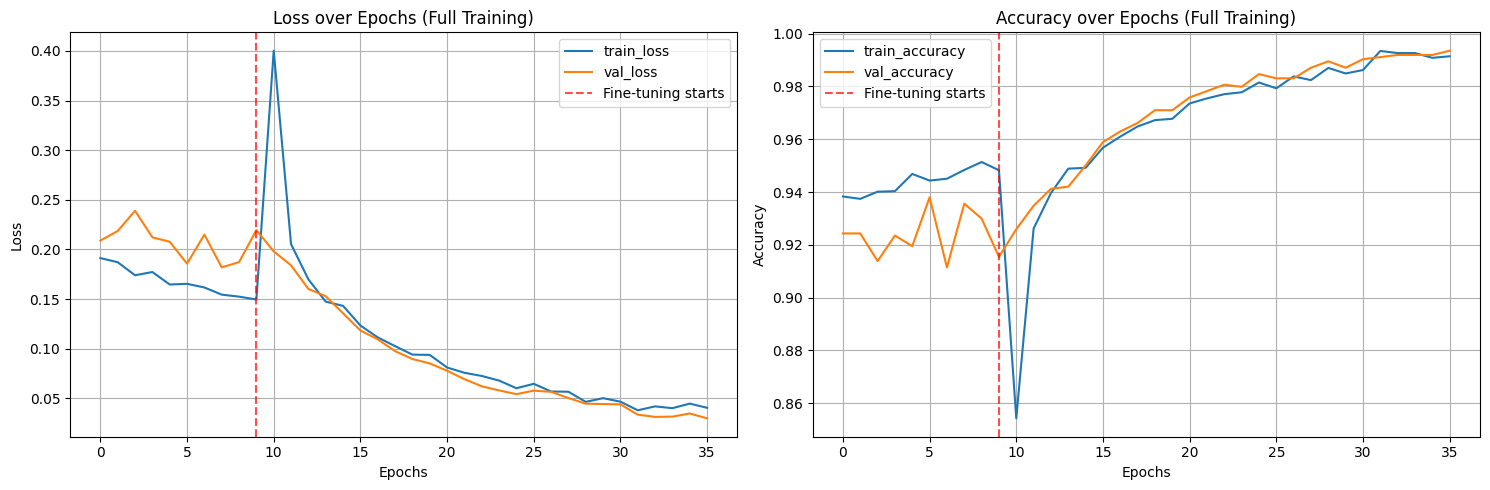

In [ ]:
plt.figure(figsize=(15, 5))

# Use total_history if available (after fine-tuning), otherwise use history
plot_history   = total_history if 'total_history' in locals() else history.history
initial_epochs = len(history.history['loss']) if 'total_history' in locals() else 0

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(plot_history['loss'], label='train_loss')
plt.plot(plot_history['val_loss'], label='val_loss')
if initial_epochs > 0:
    plt.axvline(x=initial_epochs-1, color='red', linestyle='--', alpha=0.7, label='Fine-tuning starts')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs (Full Training)')
plt.grid(True)

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(plot_history['accuracy'], label='train_accuracy')
plt.plot(plot_history['val_accuracy'], label='val_accuracy')
if initial_epochs > 0:
    plt.axvline(x=initial_epochs-1, color='red', linestyle='--', alpha=0.7, label='Fine-tuning starts')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs (Full Training)')
plt.grid(True)

plt.tight_layout()

# Save the figure
plt.savefig(results_path + 'Loss_accuracy_FineTuned.png', dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
# Final evaluation with Test Time Augmentation
print("PERFORMING FINAL EVALUATION WITH TEST TIME AUGMENTATION")

# Load the final optimized model
final_model_path = os.path.join(results_path, '_OptimallyBalanced_Final.keras')
try:
    final_model = tf.keras.models.load_model(final_model_path)
    print("Final model loaded successfully.")
except Exception as e:
    print(f"Could not load final model: {e}")
    final_model = model  # Use current model if loading fails

if final_model and 'tta_test_datasets' in locals() and 'predict_with_tta' in locals():
    print("\nExecuting Test Time Augmentation on final model...")

    # Perform TTA prediction
    tta_predictions, _ = predict_with_tta(final_model, tta_test_datasets, verbose=True)

    # Get final predictions and true labels
    tta_pred_classes = np.argmax(tta_predictions, axis=1)
    y_true_tta = tta_test_datasets[0].classes

    # Calculate final TTA accuracy
    final_tta_accuracy = accuracy_score(y_true_tta, tta_pred_classes)

    new_acc = accuracy_score(test_ds.classes, standard_pred_classes)

    print(f"\nFINAL RESULTS:")
    print(f"Standard Test Accuracy: {new_acc*100:.4f}%")
    print(f"TTA Enhanced Accuracy: {final_tta_accuracy*100:.4f}%")
    print(f"Performance Improvement: +{(final_tta_accuracy - new_acc)*100:.4f}%")

else:
    print("TTA functions or datasets not available.")


PERFORMING FINAL EVALUATION WITH TEST TIME AUGMENTATION
Final model loaded successfully.

Executing Test Time Augmentation on final model...

Performing TTA with 5 augmentations...
  - Running prediction with augmentation 1...
    Average confidence: 0.9800
  - Running prediction with augmentation 2...
    Average confidence: 0.9796
  - Running prediction with augmentation 3...
    Average confidence: 0.9905
  - Running prediction with augmentation 4...
    Average confidence: 0.9883
  - Running prediction with augmentation 5...
    Average confidence: 0.9855
  - Averaging predictions from 5 augmentations...
  - Final ensemble confidence: 0.9820

FINAL RESULTS:
Standard Test Accuracy: 98.2386%
TTA Enhanced Accuracy: 99.9199%
Performance Improvement: +1.6813%


In [ ]:
#1- Evaluate the model on the test data using `evaluate`
_, accuracy = model.evaluate(test_ds, batch_size=32)
print()
print('evaluation accuracy is :  %.3f' % (accuracy * 100.0))
print()

40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - accuracy: 0.9952 - loss: 0.0142

evaluation accuracy is :  98.879



40/40 ━━━━━━━━━━━━━━━━━━━━ 39s 542ms/step


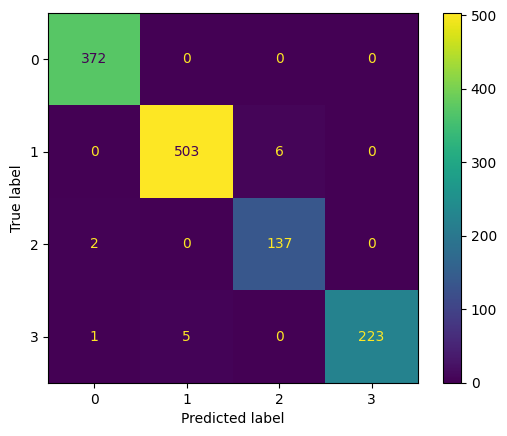

In [ ]:
predictions            = model.predict(test_ds)
y_test                 = test_ds.classes

y_pred                 = np.argmax(predictions, axis=1)  # Get the index of the maximum value
cm                     = confusion_matrix(y_test, y_pred)

cmd                    = ConfusionMatrixDisplay(confusion_matrix=cm)
cmd.plot(include_values= True, cmap='viridis', ax=None, xticks_rotation='horizontal')

# Save the figure (Fixed typo: resuts_path -> results_path)
plt.savefig(results_path + 'Confusion Matrix.png', dpi=300, bbox_inches='tight')

plt.show()

40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 104ms/step
DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

        Cyst       0.99      1.00      1.00       372
      Normal       0.99      0.99      0.99       509
       Stone       0.96      0.99      0.97       139
       Tumor       1.00      0.97      0.99       229

    accuracy                           0.99      1249
   macro avg       0.99      0.99      0.99      1249
weighted avg       0.99      0.99      0.99      1249


PER-CLASS PERFORMANCE SUMMARY:
Class      Count    Precision  Recall   F1-Score Status      
Cyst            372     0.9920   1.0000   0.9960 EXCELLENT   
Normal          509     0.9902   0.9882   0.9892 EXCELLENT   
Stone           139     0.9580   0.9856   0.9716 VERY GOOD   
Tumor           229     1.0000   0.9738   0.9867 VERY GOOD   
EXCELLENT PERFORMANCE: Cyst, Normal
GOOD PERFORMANCE: Stone, Tumor
ALL CLASSES PERFORMING EXCELLENTLY!


<Figure size 1200x800 with 0 Axes>

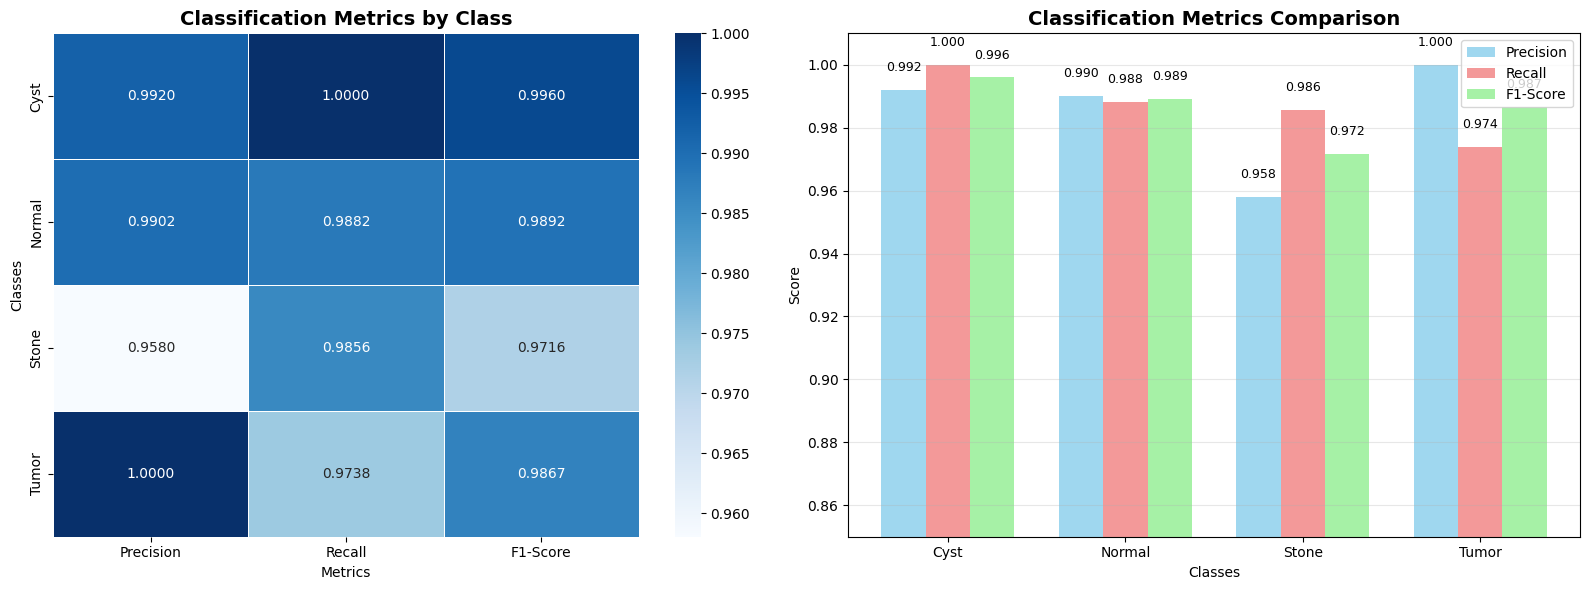

In [ ]:
predictions_test = model.predict(test_ds)
y_test           = test_ds.classes

predicted_classes = [np.argmax(pred) for pred in predictions_test]

print("DETAILED CLASSIFICATION REPORT:")
print(classification_report(y_test, predicted_classes, target_names=classes))

# Enhanced per-class analysis with performance status
report = classification_report(y_test, predicted_classes, target_names=classes, output_dict=True)
metrics = {label: report[label] for label in classes if label in report}

# Get test set class counts for context
test_class_counts = np.bincount(y_test)

print(f"\nPER-CLASS PERFORMANCE SUMMARY:")
print("=" * 70)
print(f"{'Class':10} {'Count':8} {'Precision':10} {'Recall':8} {'F1-Score':8} {'Status':12}")
print("=" * 70)

excellent_classes = []
good_classes = []
needs_attention = []

for i, class_name in enumerate(classes):
    if class_name in metrics:

        count = test_class_counts[i] if i < len(test_class_counts) else 0
        prec  = metrics[class_name]['precision']
        rec   = metrics[class_name]['recall']
        f1    = metrics[class_name]['f1-score']

        # Determine performance status
        if prec >= 0.98 and rec >= 0.98 and f1 >= 0.98:
            status = "EXCELLENT"
            excellent_classes.append(class_name)
        elif prec >= 0.95 and rec >= 0.95 and f1 >= 0.95:
            status = "VERY GOOD"
            good_classes.append(class_name)
        elif prec >= 0.90 and rec >= 0.90 and f1 >= 0.90:
            status = "GOOD"
            good_classes.append(class_name)
        else:
            status = "NEEDS ATTENTION"
            needs_attention.append(class_name)

        print(f"{class_name:10} {count:8d} {prec:10.4f} {rec:8.4f} {f1:8.4f} {status:12}")

print("=" * 70)

# Performance summary
if excellent_classes:
    print(f"EXCELLENT PERFORMANCE: {', '.join(excellent_classes)}")
if good_classes:
    print(f"GOOD PERFORMANCE: {', '.join(good_classes)}")
if needs_attention:
    print(f"NEEDS ATTENTION: {', '.join(needs_attention)}")
else:
    print("ALL CLASSES PERFORMING EXCELLENTLY!")

# Create visualization
precision_list = [metrics[label]['precision'] for label in classes]
recall_list    = [metrics[label]['recall'] for label in classes]
f1_score_list  = [metrics[label]['f1-score'] for label in classes]

data = {
          'Precision': precision_list,
          'Recall': recall_list,
          'F1-Score': f1_score_list
       }

df = pd.DataFrame(data, index=classes)

plt.figure(figsize=(12, 8))

# Create subplots for better visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Heatmap
sns.heatmap(df, annot=True, cmap='Blues', fmt=".4f", linewidths=0.5, ax=ax1)
ax1.set_title('Classification Metrics by Class', fontsize=14, fontweight='bold')
ax1.set_xlabel('Metrics')
ax1.set_ylabel('Classes')

# Bar plot for better comparison
x = np.arange(len(classes))
width = 0.25

bars1 = ax2.bar(x - width, precision_list, width, label='Precision', alpha=0.8, color='skyblue')
bars2 = ax2.bar(x, recall_list, width, label='Recall', alpha=0.8, color='lightcoral')
bars3 = ax2.bar(x + width, f1_score_list, width, label='F1-Score', alpha=0.8, color='lightgreen')

ax2.set_xlabel('Classes')
ax2.set_ylabel('Score')
ax2.set_title('Classification Metrics Comparison', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(classes)
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')
ax2.set_ylim(0.85, 1.01)

# Add value labels on bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig(results_path + 'Enhanced_Classification_Report.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
y_pred_probs = model.predict(test_ds)
y_pred       = np.argmax(y_pred_probs, axis=1)
y_true       = test_ds.classes

# Calculate metrics with proper averaging for multi-class
precision_weighted    = precision_score(y_true, y_pred, average='weighted')
recall_weighted       = recall_score(y_true, y_pred, average='weighted')
f1_weighted           = f1_score(y_true, y_pred, average='weighted')

print(f"Weighted Precision: {precision_weighted:.4f}")
print(f"Weighted Recall   : {recall_weighted:.4f}")
print(f"Weighted F1-score : {f1_weighted:.4f}")

# Also show macro averages
precision_macro = precision_score(y_true, y_pred, average='macro')
recall_macro    = recall_score(y_true, y_pred, average='macro')
f1_macro        = f1_score(y_true, y_pred, average='macro')

print(f"\nMacro Precision: {precision_macro:.4f}")
print(f"Macro Recall   : {recall_macro:.4f}")
print(f"Macro F1-score : {f1_macro:.4f}")

40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 103ms/step
Weighted Precision: 0.9889
Weighted Recall   : 0.9888
Weighted F1-score : 0.9888

Macro Precision: 0.9850
Macro Recall   : 0.9869
Macro F1-score : 0.9859


In [ ]:
# Extract true label from image path
def extract_true_label(img_path):
    print(img_path)
    folder_name = os.path.basename(os.path.dirname(img_path))
    print(folder_name)

    if "Cyst" in folder_name:
        return "Cyst"
    elif "Normal" in folder_name:
        return "Normal"
    elif "Stone" in folder_name:
        return "Stone"
    elif "Tumor" in folder_name:
        return "Tumor"

    return "Unknown"

# Load and preprocess image using the SAME pipeline as training
def load_and_preprocess_image(img_path, target_size):
    if img_path.startswith('http'):
        response = requests.get(img_path)
        img = Image.open(BytesIO(response.content)).convert("RGB")
    else:
        img = image.load_img(img_path)

    # Resize image explicitly
    img = img.resize(target_size)

    # Convert to array
    img_array = image.img_to_array(img)

    # CRITICAL: Apply the SAME preprocessing pipeline as training
    img_array = kidney_preprocessing_pipeline(img_array)

    # Add batch dimension
    img_array = np.expand_dims(img_array, axis=0)

    return img, img_array

/kaggle/working/CT_dataset/test/Cyst/Cyst- (100).jpg
Cyst
1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step


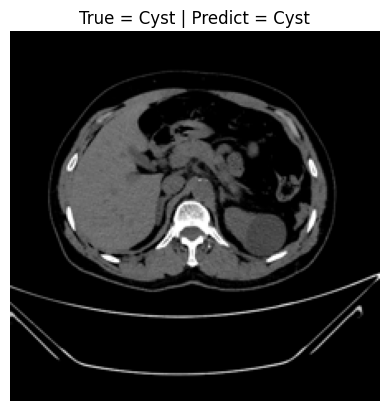

True = Cyst    Predict = Cyst


In [ ]:
# Image path (URL or local)
img_path = test_dir + '/Cyst/Cyst- (100).jpg'#Cyst- (4).jpg

# Extract true label
true_label     = extract_true_label(img_path)

# Load and preprocess image
img, img_array = load_and_preprocess_image(img_path, img_size)

# Make prediction
pred = model.predict(img_array)
pred_index = np.argmax(pred, axis=1)

class_labels = ["Cyst", "Normal", "Stone", "Tumor"]
predicted_label = class_labels[pred_index[0]]

# Display image
plt.imshow(img)
plt.axis('off')
plt.title(f"True = {true_label} | Predict = {predicted_label}")
plt.show()

# Print result
print(f"True = {true_label}    Predict = {predicted_label}")